In [1]:
%matplotlib inline

from collections import defaultdict
import functools
import os
import math

import matplotlib
import numpy as np
import pandas as pd
import pybedtools
import pysam
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from gscripts.encode import encode_helpers
from gscripts.general import dataviz
from gscripts import qtools

tqdm.pandas("Progress: ")

xfmt = matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x) / 1000000, ','))
sns.set_style("ticks")
img_dir = "/home/gpratt/Dropbox/Pratt_Gabriel/PapersInProgress/eCLIP_qc/working_figures/fig_2"

In [2]:
import matplotlib as mpl
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [3]:
input_norm_dir = "/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_CLIPperv2_20170130"
split_dir = "/home/gpratt/projects/idr/analysis/idr_v1/"
out_dir = "/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/"
downsample_path = "/home/gpratt/projects/idr/analysis/downsample_v2/"

# Make negative and positive genes for my crazy bigwig format

In [4]:
foo = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/regions/hg19_genes.bed")

def make_neg_chrom(interval):
    if interval.strand == "-":
        interval.chrom = "neg_" + interval.chrom
    return interval

foo = foo.each(make_neg_chrom).saveas("/home/gpratt/clipper/clipper/data/regions/hg19_neg_and_pos_genes.bed")

# Load all the data

In [5]:
merged_data = encode_helpers.get_merged_data()

#For Peak Analysis we only want to analyze datasets that have been submitted
merged_data = merged_data[merged_data.submitted]
merged_data = merged_data[['CLIP', 'INPUT', 'input_norm']]

In [6]:
len(merged_data) / 20. 

18.1

In [7]:
#Get all downsampled datasets and also put them into a tidy dataframe
merged_data = merged_data.set_index("INPUT", append=True)
merged_data.columns = pd.MultiIndex.from_tuples([("CLIP", 1.0), ("input_norm", 1.0)], names=["input_norm", "fraction"])

for percent in range(1,10):
    percent_downsample = "0{}".format(percent)
    merged_data[('CLIP', percent / 10.)] = merged_data[("CLIP", 1.0)].apply(lambda x: downsample_path + os.path.basename(x).replace(".bam", ".{}.bam".format(percent_downsample)))
    merged_data[('input_norm', percent / 10.)] = merged_data[("CLIP", 1.0)].apply(lambda x: downsample_path + os.path.basename(x).replace(".bam", ".{}.peaks.norm.compressed.bed".format(percent_downsample)))

merged_data = merged_data.stack()
merged_data = merged_data.reset_index()
merged_data = merged_data.set_index([u'uID',u'RBP', u'Cell line', "rep", u'fraction'])
merged_data = merged_data.sort_index()

In [8]:
#Get all the counts
counts_list = pd.read_csv("downsample_counts_full_v4.csv", dtype={"RBP_ID": str, "bio_rep": str, "tech_rep": str},
                         index_col=["RBP_ID", "RBP", "bio_rep", "tech_rep", "fraction"])
counts_list = counts_list.groupby(level=['RBP_ID', "RBP", "bio_rep", 'fraction']).sum()
counts_list.index.rename(["uID", "RBP", "rep", 'fraction'], inplace=True)
counts_list.index = counts_list.index.droplevel("RBP")

counts_list['rep'] = ["rep1" if rep == 1 else "rep2" for rep in counts_list.index.get_level_values(level="rep")]
counts_list.index = counts_list.index.droplevel("rep")
counts_list = counts_list.set_index("rep", append=True)
counts_list = counts_list.swaplevel("fraction", "rep")

In [9]:
merged_data = merged_data.reset_index(['Cell line', 'RBP'])

merged_data = pd.merge(merged_data, counts_list,
        left_index=True, right_index=True, how="left")

merged_data = merged_data.set_index(["RBP", "Cell line"], append=True)
merged_data = merged_data.reorder_levels(['uID','RBP', 'Cell line','rep', 'fraction'])

# BigWig Creation

In [10]:
out_dir = "/home/gpratt/projects/idr/analysis/downsample_wigs_v2"
def format_wig(fn):
    return os.path.join(out_dir, os.path.basename(os.path.splitext(fn)[0]) + ".wig")

def wig_script(fn):
    wig_fn = format_wig(fn)
    return "genomeCoverageBed -ibam {} -bg -split > {}".format(fn, wig_fn), wig_fn

def format_bw(fn, out_dir="/home/gpratt/projects/idr/analysis/downsample_wigs_v2"):
    return os.path.join(out_dir, os.path.basename(os.path.splitext(fn)[0]) + ".bw")

def bw_script(fn):
    return "wigToBigWig -keepAllChromosomes {} /projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes {}".format(fn, format_bw(fn))

def format_final_cmd(fn):
    wig_cmd, wig_fn = wig_script(fn)
    bw_cmd = bw_script(wig_fn)

    return wig_cmd + " && " + bw_cmd 

def stranded_bw_script(bam, out_dir="/home/gpratt/projects/idr/analysis/downsample_wigs_v2", five_prime=False):
    bw = format_bw(bam, out_dir=out_dir)
    
    five_prime_str = ""
    if five_prime:
        five_prime_str = "--five_prime"
    cmd = "python /home/gpratt/gscripts/gscripts/general/make_stranded_bw.py --bam {} --bw {} {}".format(bam, bw, five_prime_str)
    return cmd 

In [36]:
five_prime_bw_script = functools.partial(stranded_bw_script, out_dir="/home/gpratt/projects/idr/analysis/downsample_wigs_five_prime", five_prime=True)
five_prime_format_bw = functools.partial(format_bw, out_dir="/home/gpratt/projects/idr/analysis/downsample_wigs_five_prime")

merged_data['five_prime_bw'] = merged_data.CLIP.apply(five_prime_format_bw)
merged_data['bw'] = merged_data.CLIP.apply(format_bw)

total_datasets = merged_data.xs(1.0, level="fraction").copy()
total_datasets['input_bw'] = total_datasets.INPUT.apply(format_bw)
total_datasets['input_five_prime_bw'] = total_datasets.INPUT.apply(five_prime_format_bw)

In [12]:
wigs_to_be_run = merged_data[~merged_data.bw.apply(os.path.exists)]
results = list(wigs_to_be_run.CLIP.apply(stranded_bw_script).values)
results += [stranded_bw_script(item) for item in set(merged_data.INPUT) if os.path.exists(format_bw(item))]

wigs_to_be_run = merged_data[~merged_data.five_prime_bw.apply(os.path.exists)]
results += list(wigs_to_be_run.CLIP.apply(five_prime_bw_script).values)
results += [five_prime_bw_script(item) for item in set(merged_data.INPUT) if not os.path.exists(five_prime_format_bw(item))]

In [13]:
num_slices = 500
full_process_list = []
for x in range(num_slices):
    cur_list = results[x::num_slices]
    if len(cur_list) > 0:
        full_process_list.append(" && ".join(cur_list))

In [14]:
job_name = "make_wiggle_tracks"
job = qtools.Submitter(commands=full_process_list, 
                 job_name="{}".format(job_name), 
                 sh_filename="/home/gpratt/projects/idr/scripts/{}.sh".format(job_name),
                array=True,
                walltime="4:00:00",
                out_filename="/home/gpratt/projects/idr/scripts/{}.out".format(job_name),
                err_filename="/home/gpratt/projects/idr/scripts/{}.err".format(job_name),
                queue="condo")
job.job()

print "/home/gpratt/projects/idr/scripts/{}.sh".format(job_name)

/home/gpratt/projects/idr/scripts/make_wiggle_tracks.sh


running 0 tasks as an array-job.


# BigWig correlation

In [15]:
out_dir_corr = "/home/gpratt/projects/idr/analysis/correlate_wigs_v2"
def format_corr(fn):
    return os.path.join(out_dir_corr, os.path.basename(os.path.splitext(fn)[0]) + ".corr")

def format_corr_name(fn):
    return os.path.basename(os.path.splitext(fn)[0]) + ".corr"

def format_bw_correlate(rep1, rep2):
    return "bigwig_corr.py --regions /home/gpratt/clipper/clipper/data/regions/hg19_neg_and_pos_genes.bed --full {} --semi {} >> {}".format(rep1, rep2, format_corr(rep1))

In [16]:
#I'm going to ignore the correlation for just the 5' ends for now when looking at downsampling results
results = []
merged_data['corr'] = merged_data.CLIP.apply(format_corr)
corrs_to_be_run = merged_data[~merged_data['corr'].apply(os.path.exists)]
for name, row in corrs_to_be_run.iterrows():
    full_data = total_datasets.loc[name[:-1]]
    results.append(format_bw_correlate(row.bw, full_data.bw))

In [17]:
num_slices = 500
full_process_list = []
for x in range(num_slices):
    cur_list = results[x::num_slices]
    if len(cur_list) > 0:
        full_process_list.append(" && ".join(cur_list))

In [18]:
job_name = "correlate_wiggles"
job = qtools.Submitter(commands=full_process_list, 
                 job_name="{}".format(job_name), 
                 sh_filename="/home/gpratt/projects/idr/scripts/{}.sh".format(job_name),
                array=True,
                walltime="8:00:00",
                out_filename="/home/gpratt/projects/idr/scripts/{}.out".format(job_name),
                err_filename="/home/gpratt/projects/idr/scripts/{}.err".format(job_name),
                queue="condo")
job.job()

print "/home/gpratt/projects/idr/scripts/{}.sh".format(job_name)

/home/gpratt/projects/idr/scripts/correlate_wiggles.sh


running 0 tasks as an array-job.


# Plot RBP to RBP correlations

In [19]:
def correlate_format(rep1, rep2, out_dir="/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson"):
    rep1_out = os.path.basename(rep1).split(".")[0]
    rep2_out = os.path.basename(rep2).split(".")[0]

    out_total = "{}_vs_{}.corr".format(rep1_out, rep2_out)
    out_total = os.path.join(out_dir, out_total)
    return out_total

def format_bw_correlate(rep1, rep2, out_dir="/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson"):
    out_total = correlate_format(rep1, rep2, out_dir)
    return "bigwig_corr.py --regions /home/gpratt/clipper/clipper/data/regions/hg19_neg_and_pos_genes.bed --full {} --semi {} >> {}".format(rep1, rep2, out_total)

def no_size(fn):
    #Checks existance and size
    return os.path.exists(fn) and os.path.getsize(fn) == 0

In [20]:
inputs = total_datasets.xs("rep1", level="rep")

In [21]:
result = []

#CLIP
for bw_1 in total_datasets.bw:
    for bw_2 in total_datasets.bw:
        if no_size(correlate_format(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson")):
            result.append(format_bw_correlate(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson"))
            
for bw_1 in total_datasets.five_prime_bw:
    for bw_2 in total_datasets.five_prime_bw:
        if no_size(correlate_format(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson_five_prime")):
            result.append(format_bw_correlate(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson_five_prime"))

#Inputs 
for bw_1 in inputs.input_bw:
    for bw_2 in inputs.input_bw:
        if no_size(correlate_format(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson_input")):
            result.append(correlate_format(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson_input"))
        
for bw_1 in inputs.input_five_prime_bw:
    for bw_2 in inputs.input_five_prime_bw:
        if no_size(correlate_format(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson_input_five_prime")):
            result.append(format_bw_correlate(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson_input_five_prime"))

In [22]:
print len(result)

1189


In [23]:
num_slices = 500
full_process_list = []
for x in range(num_slices):
    cur_list = result[x::num_slices]
    if len(cur_list) > 0:
        full_process_list.append(" && ".join(cur_list))

In [24]:
job_name = "correlate_rbps"
job = qtools.Submitter(commands=full_process_list, 
                 job_name="{}".format(job_name), 
                 sh_filename="/home/gpratt/projects/idr/scripts/{}.sh".format(job_name),
                array=True,
                walltime="8:00:00",
                out_filename="/home/gpratt/projects/idr/scripts/{}.out".format(job_name),
                err_filename="/home/gpratt/projects/idr/scripts/{}.err".format(job_name),
                queue="condo")
job.job()

print "/home/gpratt/projects/idr/scripts/{}.sh".format(job_name)

/home/gpratt/projects/idr/scripts/correlate_rbps.sh


running 500 tasks as an array-job.


# Do the analysis

In [25]:
out_dir_corr = "/home/gpratt/projects/idr/analysis/correlate_wigs_v2"
def format_corr(fn):
    return os.path.join(out_dir_corr, os.path.basename(os.path.splitext(fn)[0]) + ".corr")

def format_corr_name(fn):
    return os.path.basename(os.path.splitext(fn)[0]) + ".corr"

def format_bw_correlate(rep1, rep2):
    return "bigwig_corr.py --regions /home/gpratt/clipper/clipper/data/regions/hg19_neg_and_pos_genes.bed --full {} --semi {} >> {}".format(rep1, rep2, format_corr(rep1))

In [26]:
def get_corr(fn):
    try:
        return pd.read_table(fn, header=None, names=['full', 'semi', 'corr'], sep= " ")['corr'][0]
    except IndexError:
        print fn
        return np.nan

In [27]:
merged_data['corr_value'] = merged_data['corr'].progress_apply(get_corr)

100%|██████████| 3620/3620 [01:39<00:00, 36.42it/s]


# Plot Downsampling Correlations matrix

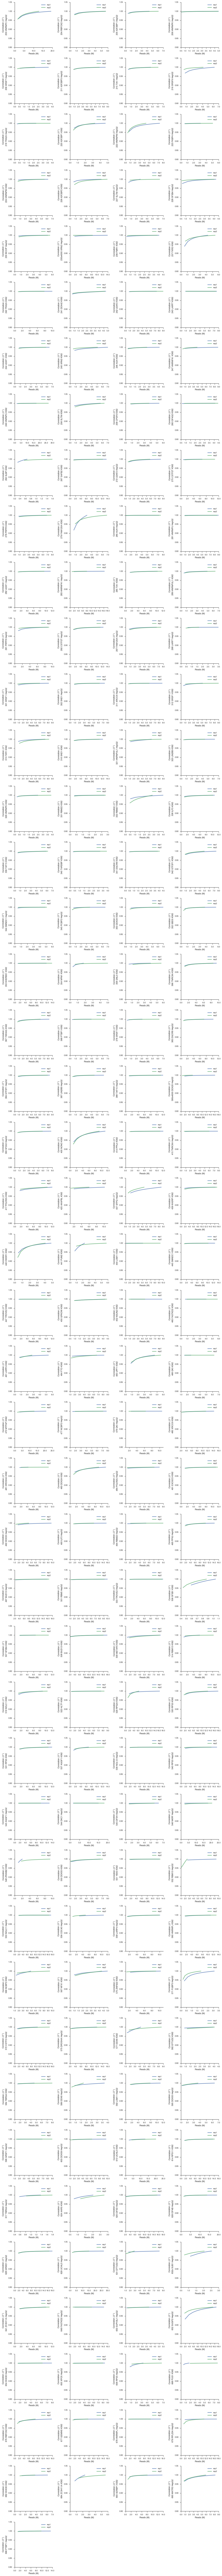

In [28]:
groups = merged_data.groupby(level=['uID', 'RBP', "Cell line"])

num_datasets = len(groups)
num_rows = math.ceil(num_datasets / 4.0) 
num_cols = 4
count = 0

with dataviz.Figure(os.path.join("/home/gpratt/Dropbox/encode_integration/qc_work/", "downsampling_reads.svg"), figsize=(4* num_cols, 4*num_rows)) as fig:
    for group, df in groups:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)

        for names, plotter in df.groupby(level=[0,1,2,3]):
            ax.plot(plotter.unique, 
                    plotter.corr_value, 
                   alpha=.7,
                   linewidth=3, 
                   label=names[-1])
            
            ax.legend()
            ax.set_ylim(.8,1.05)
            ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            ax.xaxis.set_major_formatter(xfmt)

            sns.despine(ax=ax)
            ax.set_xlabel("Reads (M)")
            ax.set_ylabel("Correlation ($R^2$)\n{}".format(" ".join(names[:-1])))


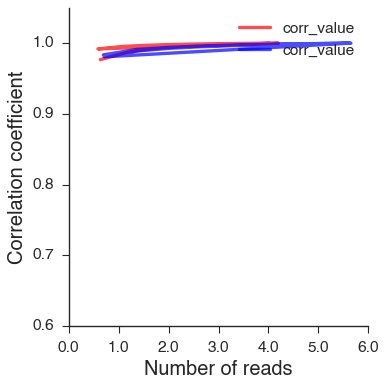

In [29]:
num_rows = 1
num_cols = 1
count = 1

with dataviz.Figure(os.path.join("/home/gpratt/Dropbox/encode_integration/qc_work/", "downsampling_reads_figure.svg"), figsize=(5* num_cols, 5*num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, count)

    uID = "228"
    df = merged_data.ix[uID]
    for rep, dataset_df in df.groupby(level=0):
        ax.plot(dataset_df.unique, dataset_df['corr_value'], 
                #label=merged_data[merged_data.uID == uID].RBP.values[0], 
                alpha=.7, linewidth=3, color='r')

    uID = "204"
    df = merged_data.ix[uID]
    for rep, dataset_df in df.groupby(level=0):
        ax.plot(dataset_df.unique, dataset_df['corr_value'], 
                #label=merged_data[merged_data.uID == uID].RBP.values[0], 
                alpha=.7, linewidth=3, color='b')
        

    ax.legend(fontsize=14)
    ax.set_ylim(.6,1.05)
    sns.despine(ax=ax)
    ax.set_ylabel("Correlation coefficient", fontsize=18)
    ax.set_xlabel("Number of reads", fontsize=18)
    
    [tick.set_fontsize(14) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(14) for tick in ax.get_yticklabels()]
    ax.get_xaxis().set_major_formatter(xfmt)


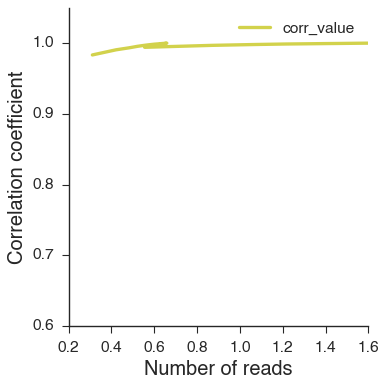

In [30]:
num_rows = 1
num_cols = 1
count = 1

with dataviz.Figure(os.path.join("/home/gpratt/Dropbox/encode_integration/qc_work/", "downsampling_reads_slbp.svg"), figsize=(5* num_cols, 5*num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, count)

    uID = "262"
    df = merged_data.ix[uID]
    for rep, dataset_df in df.groupby(level=0):
        ax.plot(dataset_df.unique, dataset_df['corr_value'], 
                #label=merged_data[merged_data.uID == uID].RBP.values[0], 
                alpha=.7, linewidth=3, color='y')
        
#     uID = "243"
#     df = result_df.ix[uID]
#     for rep, dataset_df in df.groupby(level=0):
#         ax.plot(dataset_df.reads, dataset_df['corr'], label=merged_data[merged_data.uID == uID].RBP.values[0], 
#                 alpha=.7, linewidth=3, color='g')
        
    ax.legend(fontsize=14)
    ax.set_ylim(.6,1.05)
    sns.despine(ax=ax)
    ax.set_ylabel("Correlation coefficient", fontsize=18)
    ax.set_xlabel("Number of reads", fontsize=18)
    
    [tick.set_fontsize(14) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(14) for tick in ax.get_yticklabels()]
    ax.get_xaxis().set_major_formatter(xfmt)

# RBP to RBP desnity correlations

In [ ]:
bw_result = {}
for bw_1 in total_datasets.bw:
    for bw_2 in total_datasets.bw:
        bw_1 = os.path.basename(bw_1).split(".")[0]
        bw_2 = os.path.basename(bw_2).split(".")[0]

        bw_result[(bw_1, bw_2)] = correlate_format(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson")
        
bw_result = pd.Series(bw_result, name="file_name")
bw_result = pd.DataFrame(bw_result)
bw_result['corr'] = bw_result.file_name.progress_apply(get_corr)

 18%|█▊        | 24241/131044 [13:27<1:05:18, 27.26it/s]

In [ ]:
five_prime_bw_result = {}
for bw_1 in total_datasets.five_prime_bw:
    for bw_2 in total_datasets.five_prime_bw:
        bw_1 = os.path.basename(bw_1).split(".")[0]
        bw_2 = os.path.basename(bw_2).split(".")[0]

        five_prime_bw_result[(bw_1, bw_2)] = correlate_format(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson_five_prime")
        
five_prime_bw_result = pd.Series(five_prime_bw_result, name="file_name")
five_prime_bw_result = pd.DataFrame(five_prime_bw_result)
five_prime_bw_result['corr'] = five_prime_bw_result.file_name.progress_apply(get_corr)

In [ ]:
input_bw_result = {}
for bw_1 in inputs.input_bw:
    for bw_2 in inputs.input_bw:
        if no_size(correlate_format(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson_input")):
            input_bw_result[(bw_1, bw_2)] = correlate_format(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson_input")
        
input_bw_result = pd.Series(input_bw_result, name="file_name")
input_bw_result = pd.DataFrame(input_bw_result)
input_bw_result['corr'] = input_bw_result.file_name.progress_apply(get_corr)

In [ ]:
five_prime_input_bw_result = {}

for bw_1 in inputs.input_five_prime_bw:
    for bw_2 in inputs.input_five_prime_bw:
        if no_size(correlate_format(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson_input_five_prime")):
            five_prime_input_bw_result[(bw_1, bw_2)] = format_bw_correlate(bw_1, bw_2, "/home/gpratt/projects/idr/analysis/rbp_to_rbp_pearson_input_five_prime")
            
five_prime_input_bw_result = pd.Series(five_prime_input_bw_result, name="file_name")
five_prime_input_bw_result = pd.DataFrame(five_prime_input_bw_result)
five_prime_input_bw_result['corr'] = five_prime_input_bw_result.file_name.progress_apply(get_corr)

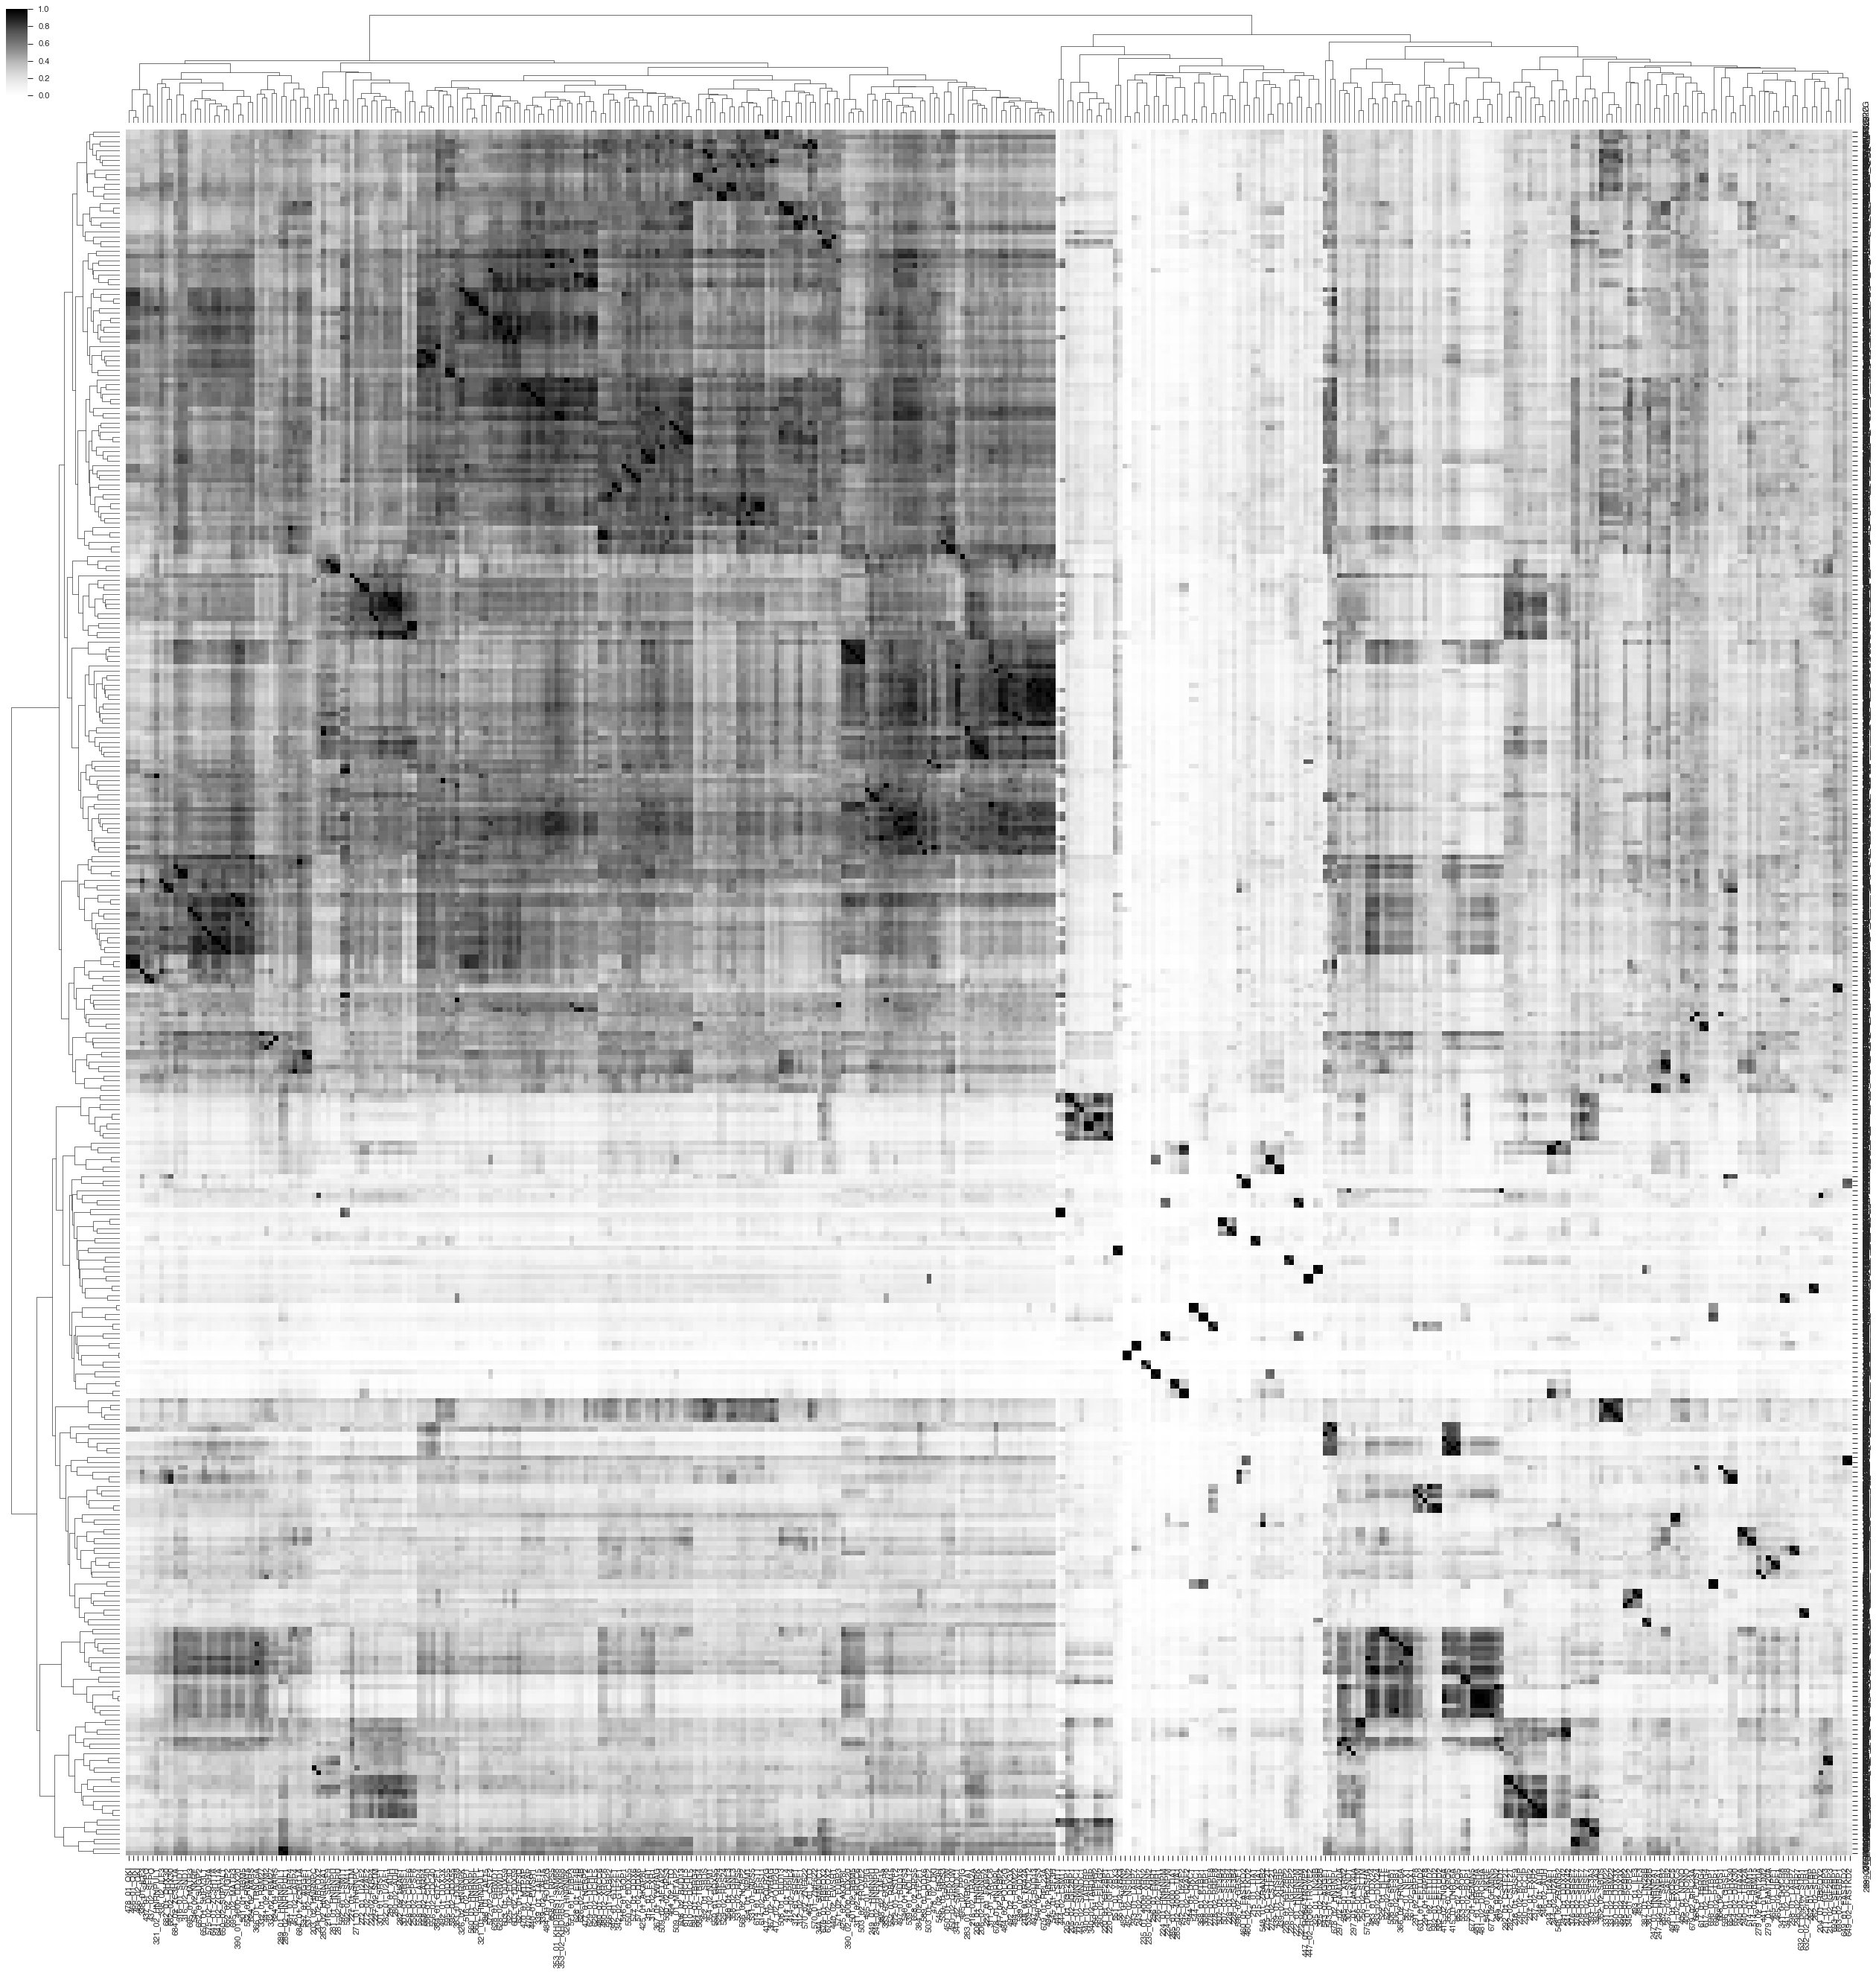

In [48]:
foo = sns.clustermap(bw_result['corr'].unstack(), cmap='Greys', vmin=0, vmax=1,
                     #col_colors=col_colors, row_colors=row_colors,
                     figsize=(40,40))

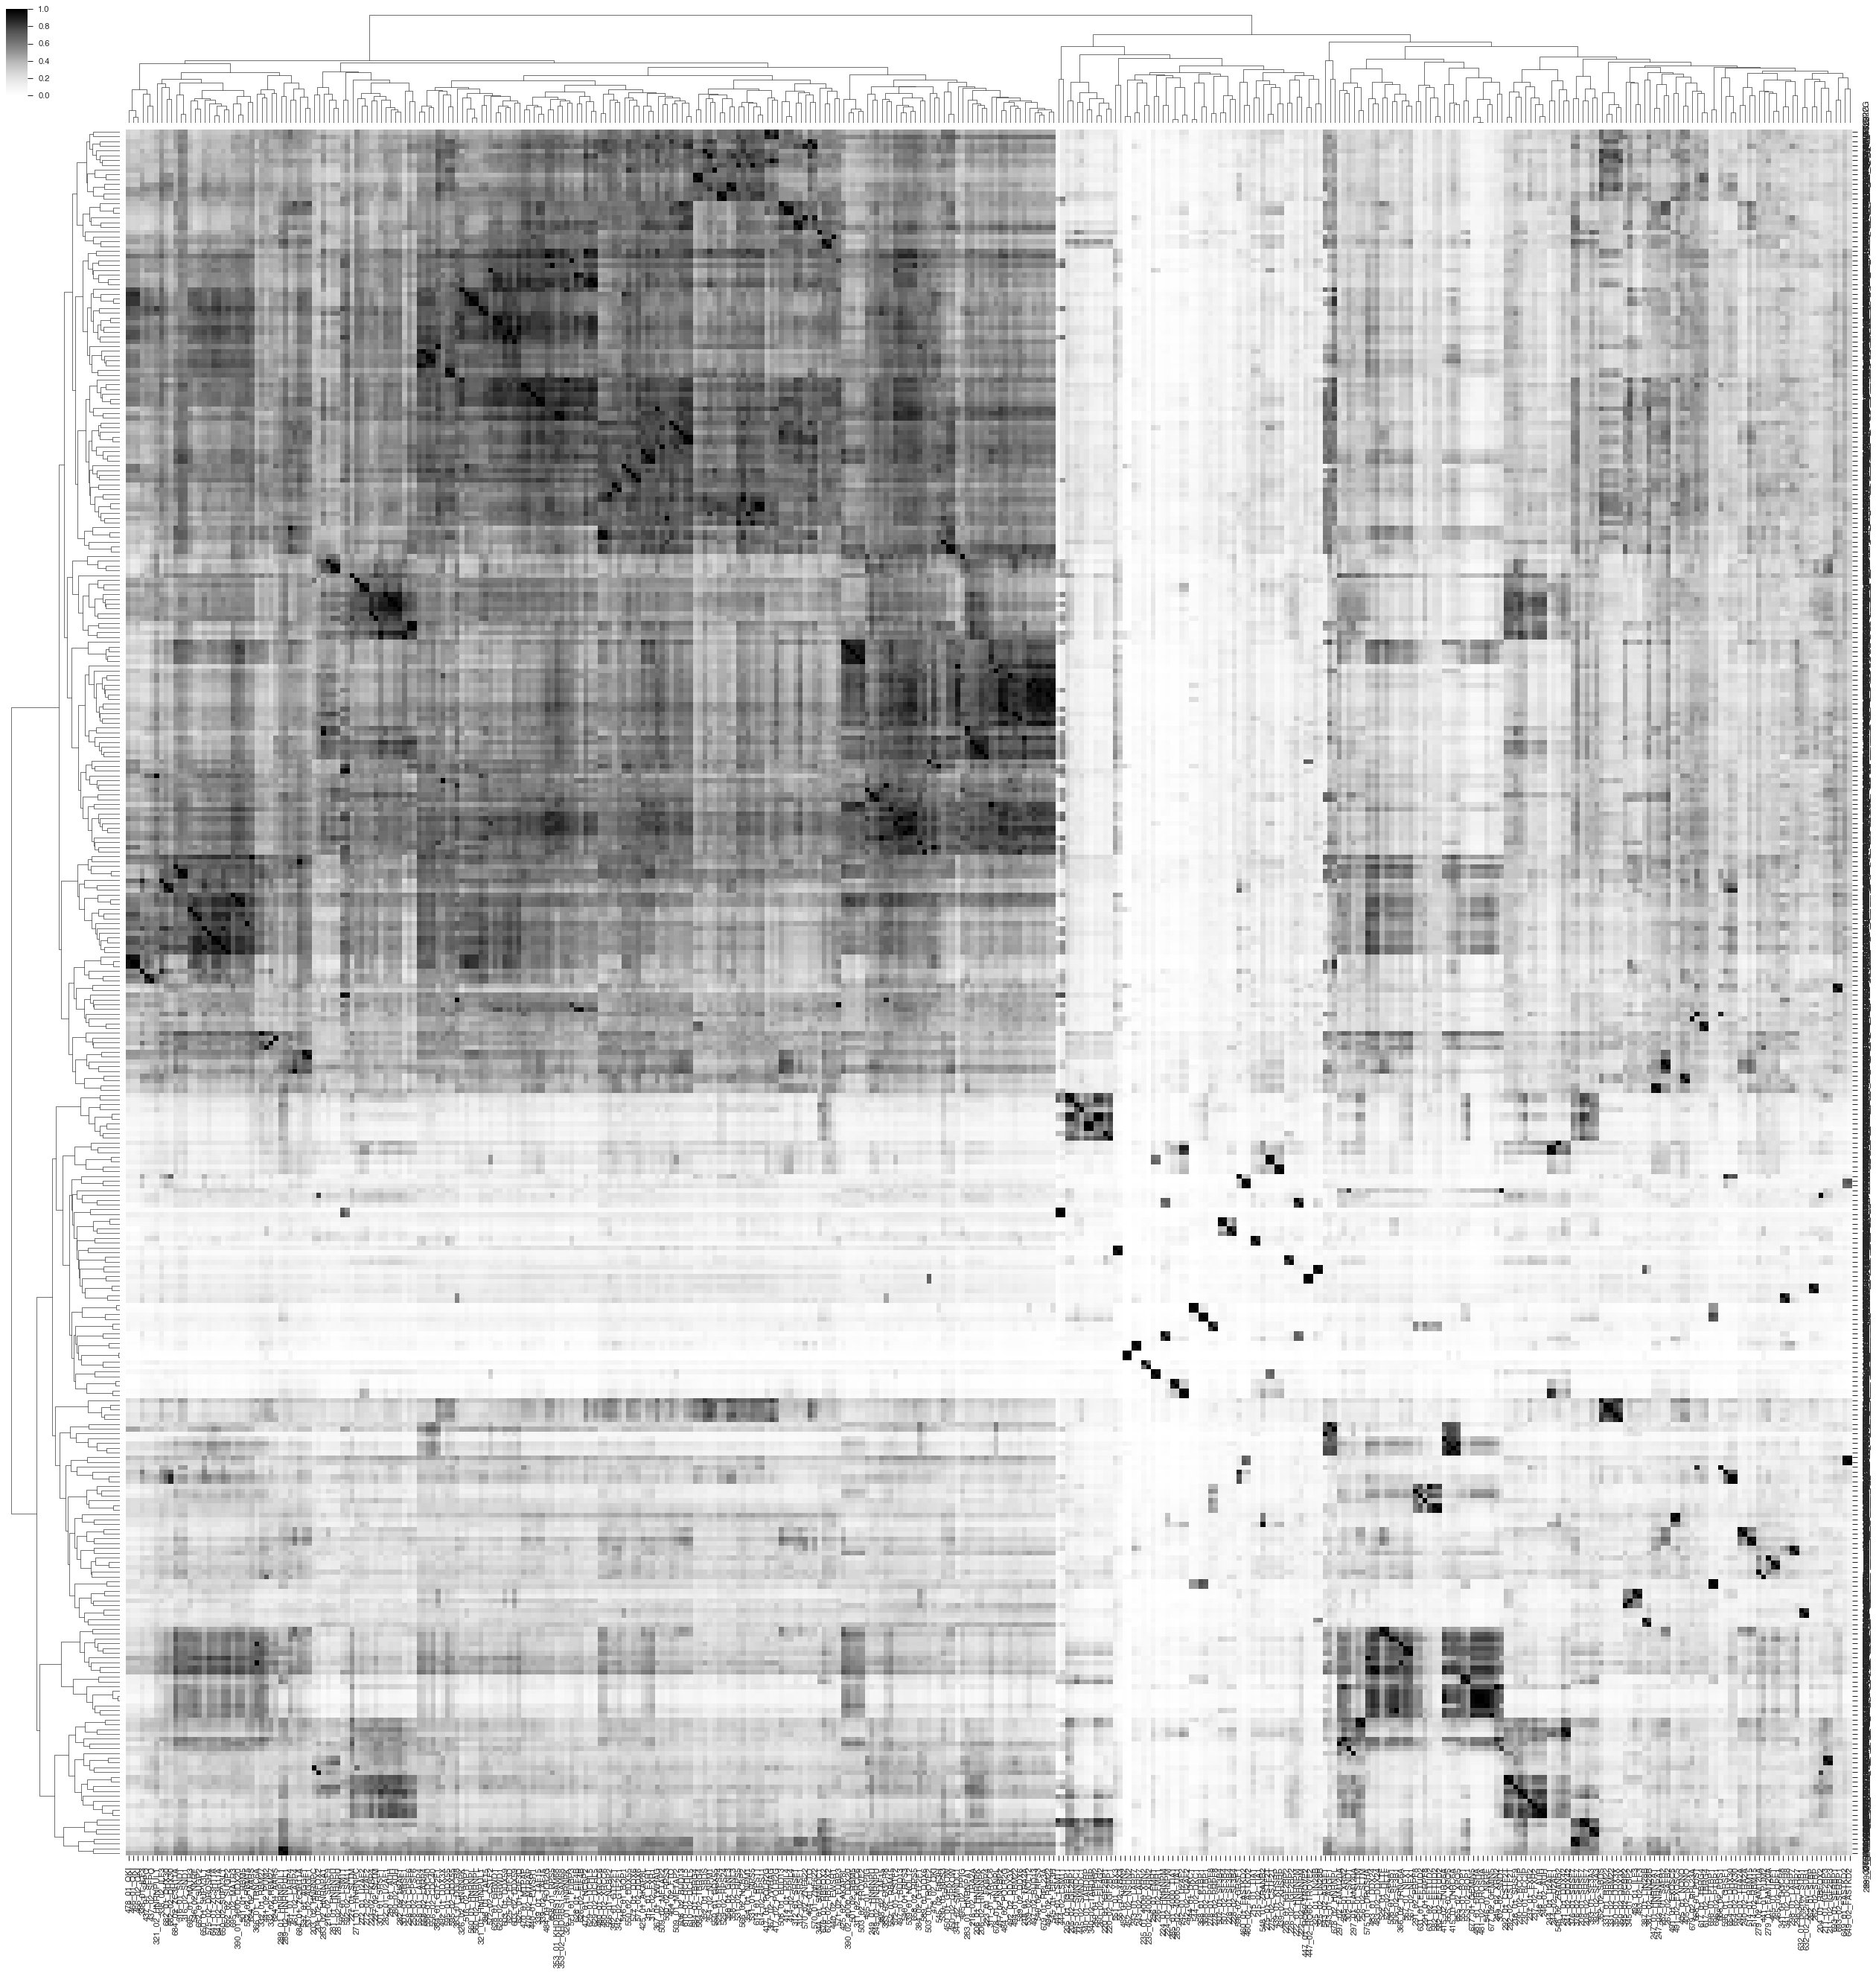

In [49]:
foo = sns.clustermap(five_prime_bw_result['corr'].unstack(), cmap='Greys', vmin=0, vmax=1,
                     #col_colors=col_colors, row_colors=row_colors,
                     figsize=(40,40))